In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, tensorboard_callback]
)

Epoch 1/1000
 1/25 ━━━━━━━━━━━━━━━━━━━━ 16s 689ms/step - accuracy: 0.1172 - loss: 1.7887
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1369 - loss: 1.7483 - val_accuracy: 0.2467 - val_loss: 1.6011
Epoch 2/1000
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2188 - loss: 1.6628
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1941 - loss: 1.6405 - val_accuracy: 0.3095 - val_loss: 1.5857
Epoch 3/1000
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1953 - loss: 1.6343
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2163 - loss: 1.6134 - val_accuracy: 0.3286 - val_loss: 1.5745
Epoch 4/1000
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2812 - loss: 1.5854
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ker

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.8140 - loss: 0.7843


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[0.00056269 0.00973195 0.36690328 0.462789   0.16001311]
3


# Confusion matrix

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


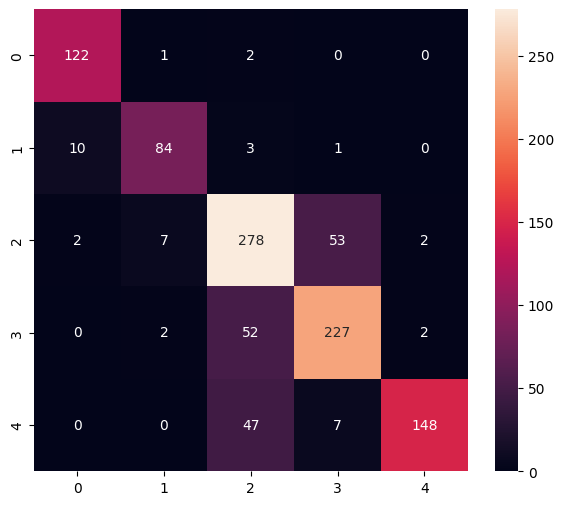

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       125
           1       0.89      0.86      0.88        98
           2       0.73      0.81      0.77       342
           3       0.79      0.80      0.80       283
           4       0.97      0.73      0.84       202

    accuracy                           0.82      1050
   macro avg       0.86      0.84      0.84      1050
weighted avg       0.83      0.82      0.82      1050



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp0rpofr9o\assets


INFO:tensorflow:Assets written to: C:\Users\ROG\AppData\Local\Temp\tmp0rpofr9o\assets


: 